In [1]:
"""
story:
let's assume we have a LIDAR
https://www.nuscenes.org/data-annotation
https://level5.lyft.com/dataset/#data-format

WE have a lidar and a detector which should detect pedestrian/traffic signs/and free space
the detector was built by someone else and we do not know anything about its quality, but we want to (and have to) use this in practice.

We want to make the best out of it using repeated measurements.

It is imporant that we assume that these measurements are completely independent form each other...which is not ture,
but we will deal with this in practice later.
"""

import numpy as np

## LIDAR Model

In [2]:
"""
class Model():
  #this is a  simple probabilistic model representing our sensor
  def __init__ (self):
    #constructor

  def GenerateState(self):
    #this function generates a random hidden state
    #has no return value

  def GetState(self):
    #this is a function we can not use inn practice, it reveals the hidden state. We will use this to check our result.
    #returns a number, the index of the hidden state (0,1,2)

  def Measure(self):
    #this funciton makes a measuerement with a previously set hidden state
    #returns the index of the measured state (0,1,2)

  def MeasureKnownState(self,X):
    #this function makes a measurement with a known hidden state
    #the hidden state is the imnput aprametre of the function (0,1,2)
    #returns the index of the measured state (0,1,2)
"""

import LIDARModel as Model

In [3]:
M = Model.Model()  # initalize this model
M.GenerateState()  # generate a random hidden state
M.GetState()  # we can check the hidden state...!this is not a measurement

1

In [4]:
# let's make 10 measurements with the known hidden states
for i in range(10):
    print(M.Measure())

1
2
1
0
1
1
1
0
0
1


# Bayesian Prediction

Get Avg Prediction Value for the given hidden state

In [5]:
sampleNum = 1000
measuredStates = np.zeros(3)
for i in range(sampleNum):
    measuredStates[M.Measure()] += 1
measuredStates /= sampleNum
print(measuredStates)

[0.303 0.59  0.107]


Get relative freq matrix (Hidden State Distribution for the measurements is fix [1/3, 1/3, 1/3] for now)

In [6]:
hStateDist = np.array([1/3, 1/3, 1/3])
sampleSnum = 30000
RFM = np.zeros((3, 3))
for hState in range(3):
    for i in range(int(sampleNum * hStateDist[hState])):
        measurement = M.MeasureKnownState(hState)
        RFM[hState][measurement] += 1
print(RFM)

[[157.  62. 114.]
 [103. 204.  26.]
 [ 31.  27. 275.]]


In [13]:
np.sum(RFM, 0)

array([291., 293., 415.])

Get observation probabilities and observation matrix

In [7]:
obsProb = np.sum(RFM, 0) / np.sum(RFM)
obsMat = RFM / np.sum(RFM, 1)
print(obsProb)
print(obsMat)

[0.29129129 0.29329329 0.41541542]
[[0.47147147 0.18618619 0.34234234]
 [0.30930931 0.61261261 0.07807808]
 [0.09309309 0.08108108 0.82582583]]


Make bayesian estimate for the actual (repeated) measurement

In [11]:
obsMat[:, measurement]

array([0.1862, 0.6126, 0.0811])

In [12]:
priorAssumption = hStateDist
obsMat[:, measurement] * priorAssumption

array([0.0621, 0.2042, 0.027 ])

In [14]:
obsMat[:, measurement] * priorAssumption / obsProb

array([0.2131, 0.6962, 0.0651])

In [8]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

sampleNum = 30
priorAssumption = hStateDist
for i in range(sampleNum):
    measurement = M.Measure()
    prediction = obsMat[:, measurement] * priorAssumption / obsProb
    prediction = prediction / np.sum(prediction)
    priorAssumption = prediction
    print(prediction)

[0.3427 0.0776 0.5797]
[0.4431 0.328  0.2289]
[0.2796 0.6763 0.0441]
[0.1117 0.8829 0.0054]
[0.0372 0.9622 0.0005]
[0.0117 0.9882 0.0001]
[0.0036 0.9964 0.    ]
[0.0011 0.9989 0.    ]
[0.0017 0.9983 0.    ]
[0.0026 0.9974 0.    ]
[0.0008 0.9992 0.    ]
[0.0012 0.9988 0.    ]
[0.0004 0.9996 0.    ]
[0.0001 0.9999 0.    ]
[0.0002 0.9998 0.    ]
[0.0001 0.9999 0.    ]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]


# Entropy

Define calculation of entropy

In [9]:
# H(X) = -sum(each k in K p(k) * log(p(k)))

def Entropy(p):
    entropy = 0
    for prob in p:
        if prob != 0:
            entropy += -prob * np.log(prob)
    return entropy

Show prediction entropy progress with Avg Prediction Value vs Bayesian Prediction

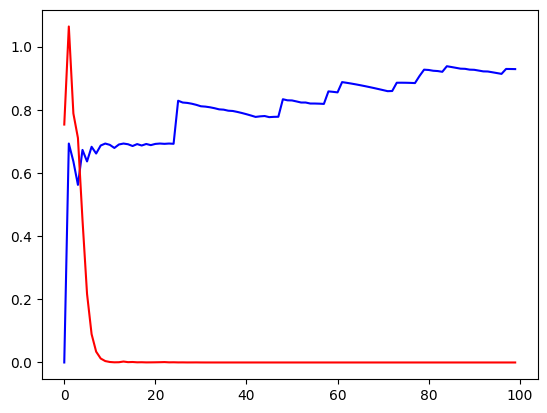

In [10]:
import matplotlib.pyplot as plt

sampleNum = 100
states = np.zeros(3)
avgEnt = np.zeros(sampleNum)
for i in range(sampleNum):
    states[M.Measure()] += 1
    prob = states/(i+1)
    avgEnt[i] = Entropy(prob)

priorAssumption = hStateDist
bayesEnt = np.zeros(sampleNum)
for i in range(sampleNum):
    measurement = M.Measure()
    prediction = obsMat[:, measurement] * priorAssumption / obsProb
    prediction = prediction / np.sum(prediction)
    bayesEnt[i] = Entropy(prediction)
    priorAssumption = prediction

plt.plot(avgEnt, 'b')
plt.plot(bayesEnt, 'r')
plt.show()

